<a href="https://colab.research.google.com/github/pafernannapi18/GithubIntro/blob/main/31St_Assigenment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Problem 1] Sharing and executing the official tutorial model

. From the Tensoflow official tutorial models, we have chosen the time series

https://www.tensorflow.org/tutorials/structured_data/time_series

. We have here the time series forecasting using Recurrent Neural Networks (RNN). The univariable time series is predicted before the multivariable ones

In [80]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [81]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [82]:
df = pd.read_csv(csv_path)

In [83]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [84]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [85]:
TRAIN_SPLIT = 300000

On the first PART the univariate time series is forecasted

In [86]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1115676690>],
      dtype=object)

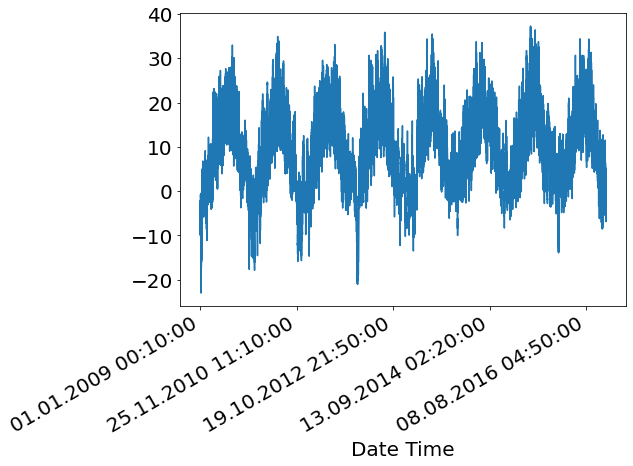

In [87]:
uni_data.plot(subplots=True)

The above is how the data looks across time

In [88]:
uni_data = uni_data.values

In [89]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [90]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [91]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [92]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [93]:
def create_time_steps(length):
  return list(range(-length, 0))

In [94]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

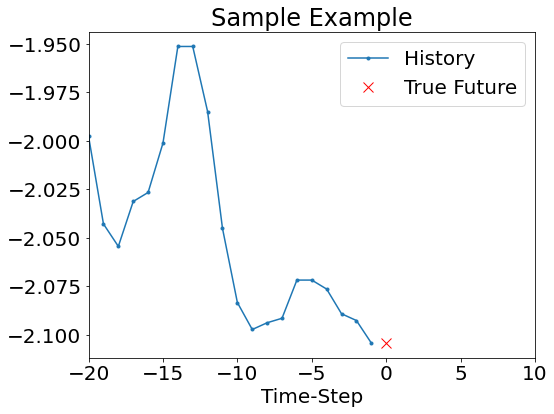

In [95]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [96]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

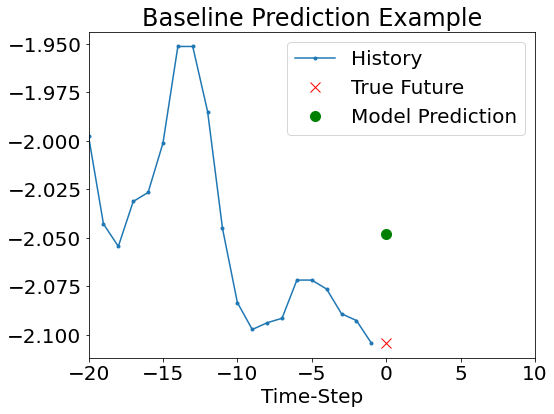

In [97]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Now the recurrent neural network comes into account

In [98]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [99]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [100]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [101]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 12ms/step - loss: 0.6160 - val_loss: 0.1099
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1090 - val_loss: 0.0373
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0493 - val_loss: 0.0295
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0423 - val_loss: 0.0263
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0290 - val_loss: 0.0239
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0313 - val_loss: 0.0222
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0285 - val_loss: 0.0209
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0266 - val_loss: 0.0204
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0262 - val_loss: 0.0191
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0237 - val_loss: 

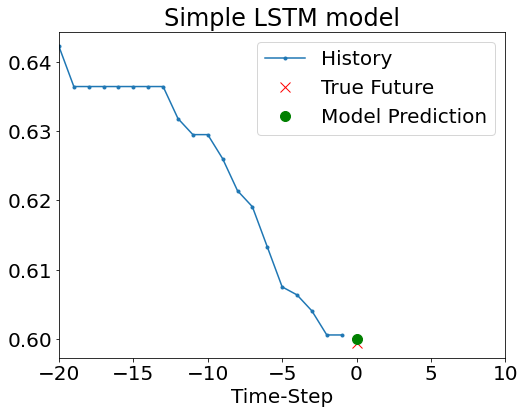

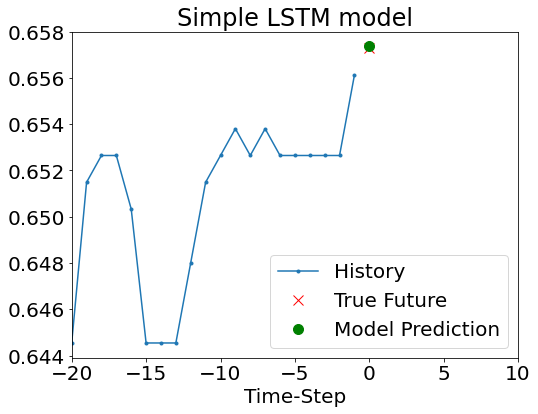

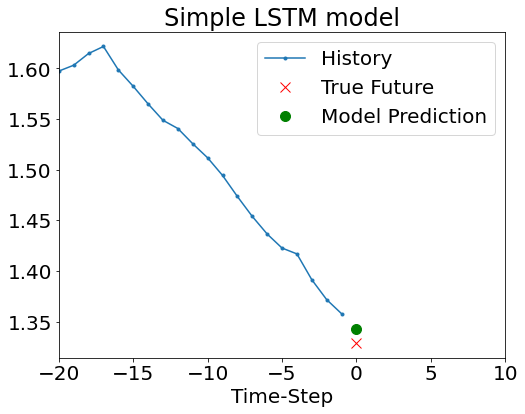

In [102]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

The above part handled the univariable, let's now move to the multivariable forecasting

In [103]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [104]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f11101f6810>,
      dtype=object)

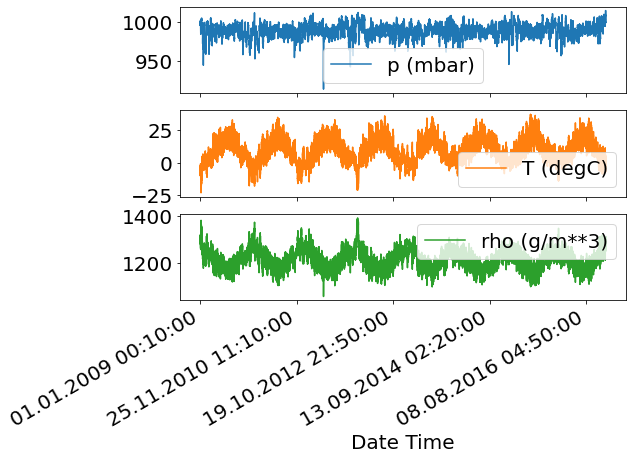

In [105]:
features.plot(subplots=True)

The above shows how each of the features vary across the time

In [106]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [107]:
dataset = (dataset-data_mean)/data_std

In [108]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [109]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [110]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [111]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [112]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [113]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [114]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 21s 96ms/step - loss: 0.3126 - val_loss: 0.2712
Epoch 2/10
200/200 [==============================] - 19s 93ms/step - loss: 0.2602 - val_loss: 0.2440
Epoch 3/10
200/200 [==============================] - 18s 92ms/step - loss: 0.2600 - val_loss: 0.2429
Epoch 4/10
200/200 [==============================] - 18s 92ms/step - loss: 0.2555 - val_loss: 0.2414
Epoch 5/10
200/200 [==============================] - 19s 93ms/step - loss: 0.2275 - val_loss: 0.2352
Epoch 6/10
200/200 [==============================] - 19s 93ms/step - loss: 0.2406 - val_loss: 0.2650
Epoch 7/10
200/200 [==============================] - 21s 107ms/step - loss: 0.2427 - val_loss: 0.2829
Epoch 8/10
200/200 [==============================] - 21s 103ms/step - loss: 0.2421 - val_loss: 0.2510
Epoch 9/10
200/200 [==============================] - 19s 93ms/step - loss: 0.2451 - val_loss: 0.2476
Epoch 10/10
200/200 [==============================] - 19s 93ms/step - loss: 0.2

In [115]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Predicting a single step feature

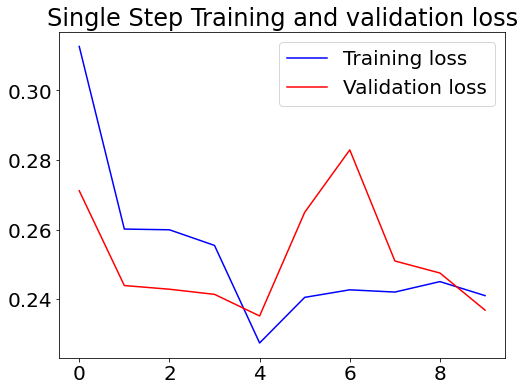

In [116]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

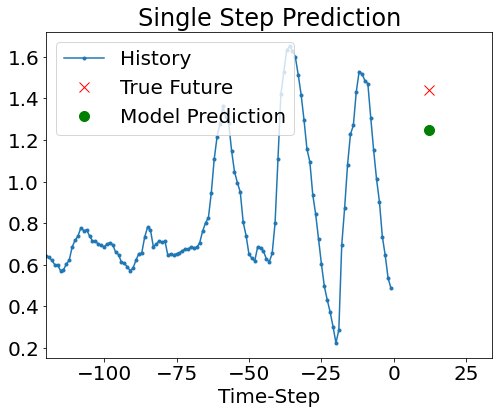

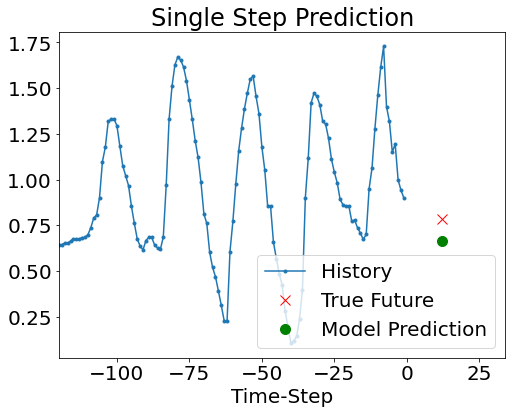

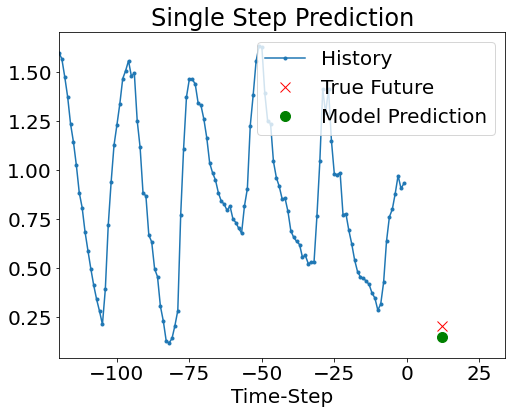

In [117]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi -Step model

In [118]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [119]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [120]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [121]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

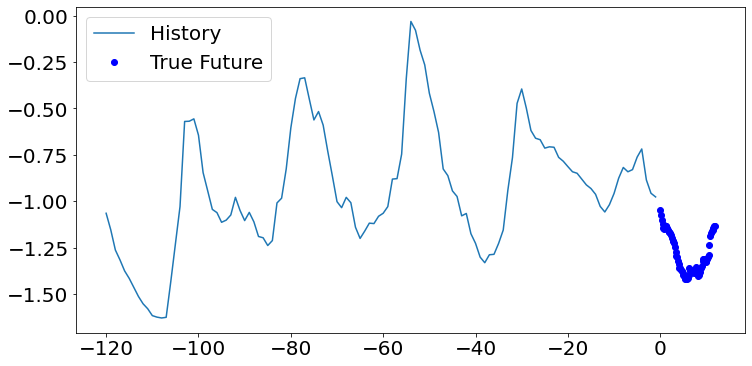

In [122]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [123]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [124]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [125]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 38s 174ms/step - loss: 1073877.0000 - val_loss: 0.3061
Epoch 2/10
200/200 [==============================] - 33s 166ms/step - loss: 4767.3296 - val_loss: 0.2928
Epoch 3/10
200/200 [==============================] - 33s 165ms/step - loss: 0.3412 - val_loss: 0.2589
Epoch 4/10
200/200 [==============================] - 34s 170ms/step - loss: 0.2548 - val_loss: 0.2138
Epoch 5/10
200/200 [==============================] - 33s 165ms/step - loss: 0.2026 - val_loss: 0.2098
Epoch 6/10
200/200 [==============================] - 33s 166ms/step - loss: 0.2119 - val_loss: 0.2102
Epoch 7/10
200/200 [==============================] - 34s 170ms/step - loss: 0.2039 - val_loss: 0.2076
Epoch 8/10
200/200 [==============================] - 33s 166ms/step - loss: 0.1987 - val_loss: 0.2051
Epoch 9/10
200/200 [==============================] - 33s 165ms/step - loss: 0.2017 - val_loss: 0.1871
Epoch 10/10
200/200 [==============================] - 33s 167ms

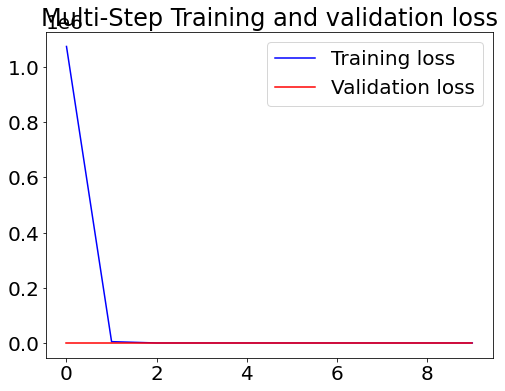

In [126]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Predicting a multi-step feature

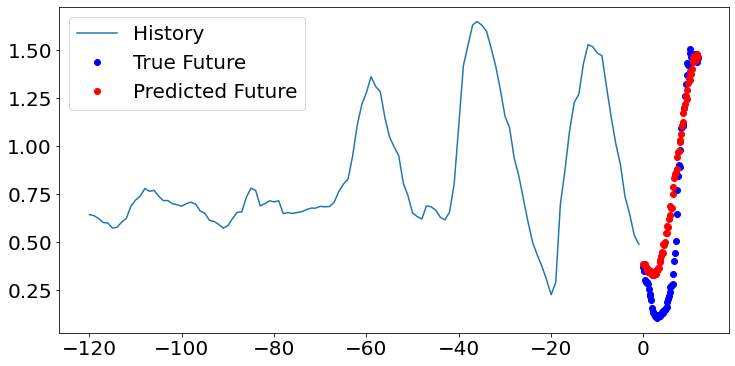

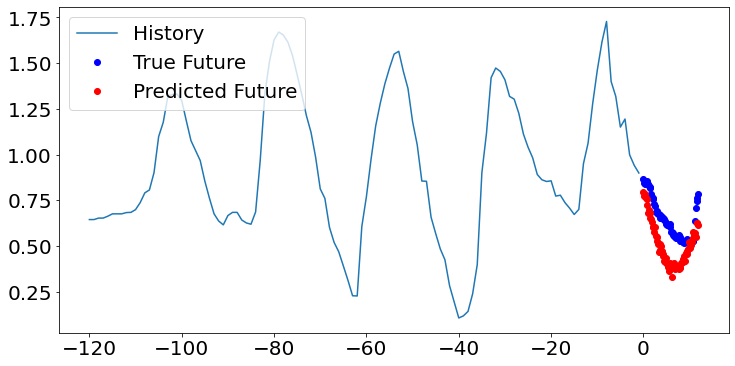

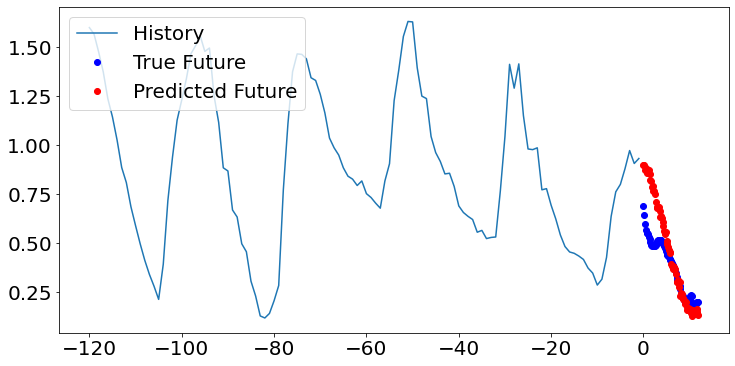

In [127]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Like we stated above, this was quick introduction to time series forecasting using an RNN

## [Problem 3] Learning Iris (binary classification) with Keras

Learning Iris (binary classification) with Keras

In [128]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

#Preparing the dataset along with the variables and target
dataset_path ="/content/drive/MyDrive/Iris.csv"
df = pd.read_csv(dataset_path)

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# Convert labels to numbers
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Further splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [129]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))

In [130]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

#Train the model
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 25ms/step - loss: 1.2991 - accuracy: 0.5312 - val_loss: 0.6143 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7459 - accuracy: 0.5625 - val_loss: 0.6233 - val_accuracy: 0.4375
Epoch 3/10
7/7 [=========================

In [131]:
#Predictions
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred_proba [0.07167172 0.9918668  0.04304355 0.99824613 0.9162077  0.9946877
 0.2626351  0.8170854  0.9973588  0.94635034 0.98430586 0.9868749
 0.9962598  0.1834954  0.00822064 0.02731863 0.72415656 0.00867054
 0.9193015  0.02135319]
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [132]:
#Evaluiation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.24461516737937927
Train accuracy: 0.8999999761581421


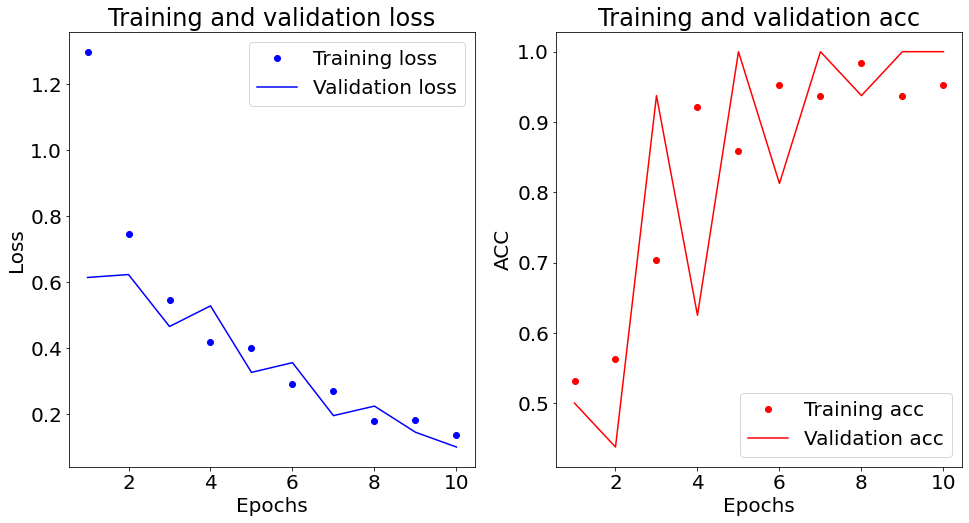

In [133]:
#Plotting the training and validation loss and accuracy
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))


plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
 
plt.show()

# [Problem 4] Learn Iris (multi-level classification) with Keras

Learning Iris (multi-level classification) with Keras

In [134]:
#Preparing the dataset along with the variables and target
dataset_path ="/content/drive/MyDrive/Iris.csv"
df = pd.read_csv(dataset_path)

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# Convert labels to numbers
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Further splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#Preprocessing / One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

In [135]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [136]:
model.summary()

#Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

#Training the model
history = model.fit(X_train, y_train_one_hot,
                    batch_size=10,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________


In [137]:
#Predictions
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred_proba [7.1913184e-11 1.1448883e-03 9.9997079e-01 4.6784767e-09 9.9951208e-01
 9.4587456e-13 9.9974626e-01 3.5193423e-04 1.6224739e-04 2.1482392e-03
 8.2694321e-08 7.6177181e-04 2.8533270e-04 2.1067254e-04 2.1357127e-04
 9.9910104e-01 3.0115963e-04 3.4656658e-04 9.9845207e-01 9.9991369e-01
 2.1366894e-08 2.9547053e-04 9.9773204e-01 9.9798191e-01 1.7348182e-05
 9.9992383e-01 9.9895918e-01 1.0836904e-03 8.2888193e-03 9.9885094e-01]
y_pred [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [138]:
#Predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [139]:
#Evaluation of the model
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.025391187518835068
Train accuracy: 1.0


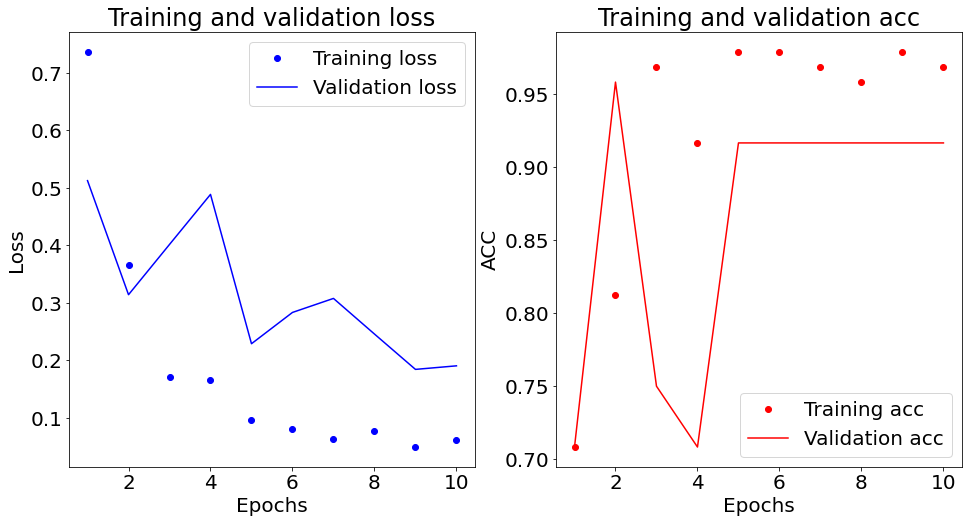

In [140]:
#Plotting the training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))


plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
 
plt.show()

# [Problem 5] Learning House Prices with Keras

Learning House Prices with Keras

In [141]:
from sklearn.preprocessing import StandardScaler

#GEtting the dataset and preparing the variables and target
train = pd.read_csv('/content/drive/MyDrive/Train dataset/train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

#Preparation of the variables and target / Preprocessing
x = np.log(x).values
y = np.log(y).values

sc = StandardScaler()
sc.fit_transform(x)

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#Further splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [142]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

In [143]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Compiling the model
model.compile(loss='mse',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['mse'])

#Training the model
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=20,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 3ms/step - loss: 2.5294 - mse: 2.5294 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 3/20
94/94 [==============================] - 0s 3ms

In [144]:
#Predictions
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba
print("y_pred", y_pred.ravel()[:5])
print('y_test', y_test.ravel()[:5])

y_pred [12.59022  12.171415 11.934428 12.40433  11.85678 ]
y_test [12.20918779 11.79810441 11.60823564 12.16525065 11.38509209]


In [145]:
#Evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('loss (test):', score[0])
print('Mean Squared Error (test):', score[1])

loss (test): 0.07328928261995316
Mean Squared Error (test): 0.07328928261995316


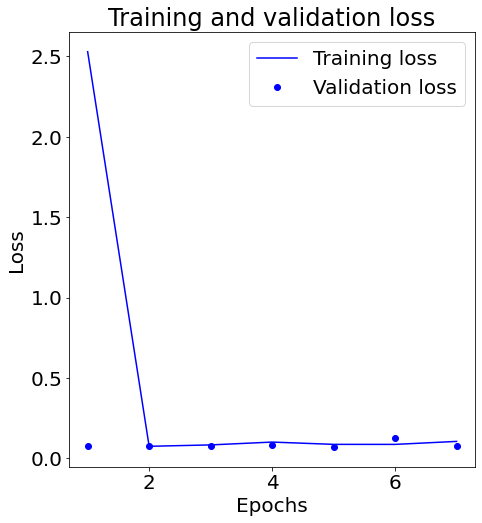

In [146]:
#Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, 8)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))

plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

# [Problem 6] Learning MNIST with 

Learning MNIST with Keras

In [147]:
# Download the MNIST dataset
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#flatten
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Type conversion, normalization
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#Splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#Preprocessing of the target variable
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [148]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

In [149]:
model.summary()

#Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy'])

#Training the model
history = model.fit(X_train, y_train_one_hot,
                    batch_size=20,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 45,360
Trainable params: 45,360
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2400/2400 [==============================] - 6s 2ms/step - loss: 0.2937 - accuracy: 0.9127 - val_loss: 0.2699 - val_accuracy: 0.9217
Epoch 2/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.1869 - accuracy: 0.9464 - val_loss: 0.1868 - val_accuracy: 0.9458
Epoch 3/5
2400/2400 [=========

In [150]:
#Predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred[:10])
print('y_test', y_test.ravel()[:10])

y_pred [7 2 1 0 4 1 4 9 5 9]
y_test [7 2 1 0 4 1 4 9 5 9]


In [152]:
#Evaluation of the model
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17325925827026367
Test accuracy: 0.9556999802589417


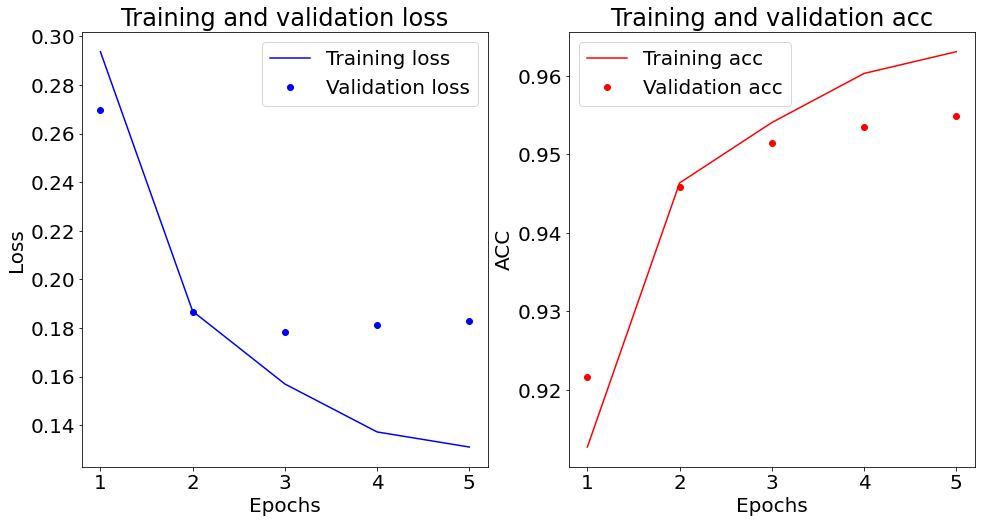

In [153]:
#Plotting the training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))


plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
 
plt.show()